## Ансамбли и полносвязные нейронные сети
В этом ноутбуке вам нужно обучить модели на датасете классификации из предыдущего ноутбука и сравнить результаты. Вам будет предоставлен baseline, на основе которого вы будете доделывать предсказывающие модели. Оценка лабы будет зависеть от ROC-AUC на тестовых данных по следующим критериям:
\
AUC - на тестовых данных
- $AUC \leq 0.76$ - 0 баллов
- $0.76 < AUC \leq 0.77$ - 2 балла
- $0.77 < AUC \leq 0.78$ - 4 балла
- $0.78 < AUC \leq 0.79$ - 6 баллов
- $0.79 < AUC \leq 0.80$ - 8 баллов
- $AUC > 0.80$ - 10 баллов


In [10]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [11]:
data = pd.read_csv('german.csv', sep=';')
print("Размерность данных:", data.shape)
print("\nПервые 5 строк:")
print(data.head())

print("\nИнформация о данных:")
print(data.info())

print("\nСтатистическое описание:")
print(data.describe())

print("\nПропущенные значения:")
print(data.isnull().sum())

Размерность данных: (1000, 21)

Первые 5 строк:
   Creditability  Account_Balance  Duration_of_Credit_monthly  \
0              1                1                          18   
1              1                1                           9   
2              1                2                          12   
3              1                1                          12   
4              1                1                          12   

   Payment_Status_of_Previous_Credit  Purpose  Credit_Amount  \
0                                  4        2           1049   
1                                  4        0           2799   
2                                  2        9            841   
3                                  4        0           2122   
4                                  4        0           2171   

   Value_Savings_Stocks  Length_of_current_employment  Instalment_per_cent  \
0                     1                             2                    4   
1                   

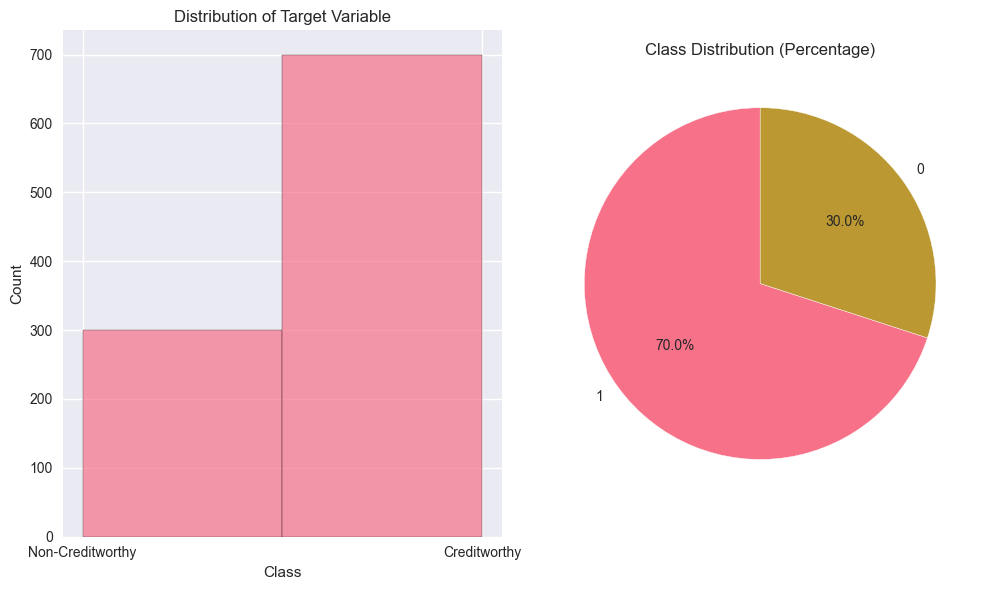

Соотношение классов: 700:300 (Creditworthy:Non-Creditworthy)
Доля кредитоспособных клиентов: 70.00%


In [12]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(data['Creditability'], bins=2, edgecolor='k', alpha=0.7)
plt.xticks([0, 1], ['Non-Creditworthy', 'Creditworthy'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Target Variable')

plt.subplot(1, 2, 2)
class_counts = data['Creditability'].value_counts()
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution (Percentage)')

plt.tight_layout()
plt.show()

print(f"Соотношение классов: {class_counts[1]}:{class_counts[0]} (Creditworthy:Non-Creditworthy)")
print(f"Доля кредитоспособных клиентов: {class_counts[1]/len(data)*100:.2f}%")

In [13]:
X = data.iloc[:, 1:].to_numpy()
y = data.iloc[:, 0].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Распределение классов в обучающей выборке: {np.bincount(y_train)}")
print(f"Распределение классов в тестовой выборке: {np.bincount(y_test)}")

Размер обучающей выборки: (800, 20)
Размер тестовой выборки: (200, 20)
Распределение классов в обучающей выборке: [240 560]
Распределение классов в тестовой выборке: [ 60 140]


In [14]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else roc_auc_score(y_test, y_pred)

    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')

    return {
        'model': model,
        'name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }

rf_base = RandomForestClassifier(n_estimators=100, random_state=42)
gb_base = GradientBoostingClassifier(n_estimators=100, random_state=42)
mlp_base = MLPClassifier(hidden_layer_sizes=(30,), max_iter=500, random_state=42)

results = []
results.append(evaluate_model(rf_base, X_train, y_train, X_test, y_test, "Random Forest (Base)"))
results.append(evaluate_model(gb_base, X_train, y_train, X_test, y_test, "Gradient Boosting (Base)"))
results.append(evaluate_model(mlp_base, X_train, y_train, X_test, y_test, "MLP (Base)"))

print("БАЗОВЫЕ МОДЕЛИ:")
print("-" * 80)
for res in results:
    print(f"\n{res['name']}:")
    print(f"  Accuracy:  {res['accuracy']:.4f}")
    print(f"  Precision: {res['precision']:.4f}")
    print(f"  Recall:    {res['recall']:.4f}")
    print(f"  ROC-AUC:   {res['roc_auc']:.4f}")
    print(f"  CV AUC:    {res['cv_mean']:.4f} (+/- {res['cv_std']:.4f})")

БАЗОВЫЕ МОДЕЛИ:
--------------------------------------------------------------------------------

Random Forest (Base):
  Accuracy:  0.8050
  Precision: 0.8137
  Recall:    0.9357
  ROC-AUC:   0.8158
  CV AUC:    0.7799 (+/- 0.0508)

Gradient Boosting (Base):
  Accuracy:  0.7900
  Precision: 0.8267
  Recall:    0.8857
  ROC-AUC:   0.8198
  CV AUC:    0.7726 (+/- 0.0454)

MLP (Base):
  Accuracy:  0.7150
  Precision: 0.7107
  Recall:    1.0000
  ROC-AUC:   0.6525
  CV AUC:    0.5994 (+/- 0.0426)


## Экспериментируйте
Для получения лучшего качества придется поэкспериментировать. Подсказка: попробуйте оптимизировать гиперпараметры модели